<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy
import time

In [2]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [3]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [4]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$)

In [5]:
g1 = G1()

Examples:

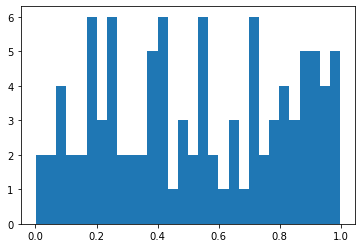

In [6]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

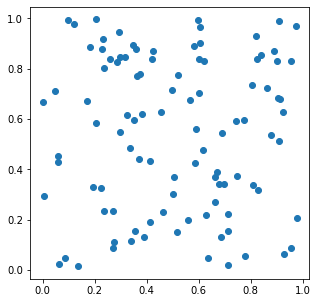

In [7]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [8]:
g1.refresh() # generate a new dataset

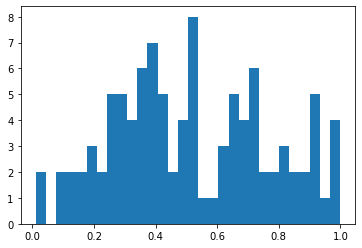

In [9]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [10]:
m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

[0.49196469 0.49196469]


### Test on log-normal distribution

In [11]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

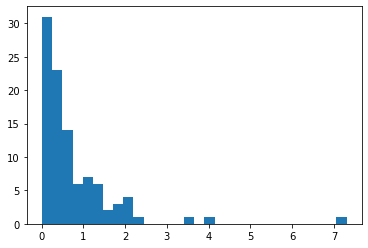

In [12]:
plt.hist(g2.v, bins=30)
plt.show()

In [13]:
g2.refresh() # to generate a new x and v

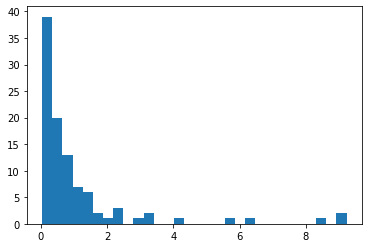

In [14]:
plt.hist(g2.v, bins=30)
plt.show()

---

# **Markdowns TO CHECK to see if everything is still all up to date and no typos!**

### Metropolis Hastings

### **1. Implementation**

Implementation of Metropolis-Hastings algorithm to find an approximate solution of $S^*(\lambda)$

**Definition of the objective function**

**Metropolis-Hastings algorithm**

The function we want to maximize is defined on $f : P[1,n] \rightarrow \mathbb{R}$.
To achieve this, we will minimize g defined as -f.

**a) Definition of the base chain**

We choose a Symmetric Random Walk on the hypercube $C = \{0,1\}^n$. States are therefore notated as vectors x of dimension n filled with 0's and 1's.

Vocabulary: we will say that x and y are neighbours if the two vectors differ by only one digit. Example: (1,0,1,0,0) and (1,0,1,1,0) are neighbours but (1,0,1,0,0) and (1,0,1,1,1) are not.

The transition matrix is the following:
$$
\psi_{xy} = \left\{
    \begin{array}{ll}
        \frac{1}{n} & \mbox{if x and y are neighbours }  \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Defined like this, it has all the necessary hypothesis to be a base chain: 
- irreducible
- $\psi_{xy} > 0$ iff $\psi_{yx} > 0$

## **TODO: prove here that we don't need aperiodicity (just like in the hw8 with the symmetric random walk on Z)!**

The idea behind taking this base chain is that a vector x of dimension n describe perfectly (meaning: without ambiguity) one set of cities S taken in $P[1,n]$.

For instance, for $n = 5$, $x = np.array([1,0,0,1,1])$ correspond to $S = \{1,4,5\}$. If the i-th digit in x is 1, it means that the i-th city is in S, if the i-th digit in x is 0, it means that the i-th city is not in S.

As a result, in the computation of the acceptance probabilities, computing g(x) will be interpreted as computing g(S) with S being the corresponding set of cities (as explained just before).

Our aim is to sample from the distribution $\pi_{\infty}(x) = \frac{\mathbb{1}_{x\ is\ a\ global\ minimum\ of\ g}}{Z_{\infty}}$.

But this is a difficult task, this is why me sample from the distribution $\pi_{\beta}$ instead $\pi_{\beta}(x) = \frac{e^{-\beta g(x)}}{Z_{\beta}}$.

But this is still difficult because of $Z_{\beta}$. This is why we will construct a Markov chain having $\pi_{\beta}$ as its stationary distribution using the Metropolis-Hastings algorithm.

**b) Definition of the acceptance probabilities**

Because if  $\psi_{xy} = \psi_{yx} = 0$ then $\frac{0}{0} = 0$ and that in any other case, $\frac{\psi_{xy}}{\psi_{yx}} = 1$, we can express the acceptance probabilities  as follows:

$$
a_{xy} = min(1, \frac{\pi_{\beta}(y)}{\pi_{\beta}(x)}) =\left\{
    \begin{array}{ll}
        min(1, e^{-\beta (g(y) - g(x))}) & \mbox{if x and y are neighbours}  \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$


Note that here, the ${Z_{\beta}}$ cancels out in the acceptance probabilities computation (this is why we used the Metropolis-Hastings algorithm to begin with).


**c) Constructing the new chain**

The transition probabilities of the new chain is defined as follows:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if } x \ne y  \\
        1 - \sum_{v\ne x}\psi_{xv}a_{xv} & x = y
    \end{array}
\right.
$$

Because $a_{xv} = 0$ when v is not a neighbour of y, the sum can be simplified. Let us note $A_x = \{y \in C | is\_neighbour(x,y) == True\}$, then:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if } x \ne y  \\
        1 - \sum_{v \in A_x}\psi_{xv}a_{xv} & x = y
    \end{array}
\right.
$$

Which is way easier to compute because the sum has now only n terms in it!

It can be even more simplified if we write like this:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if x and y are neighbours} \\
        1 - \sum_{v \in A_x}\psi_{xv}a_{xv} & \mbox{if } x = y \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Such a constructed chain will have the following property: $p_{xy}(n) \xrightarrow[n \to \infty]{} \pi_{\beta}(y)$ $\forall y$ in $C$

The idea behind the `forward()` is to find way to pick where to go on the next step without having to compute all the p_xy of y in A_x (which is expensive).

According to the lecture 11.2, one method would be to propose a move (propose to switch one of the digits), and then accept it with probability a_xy after having computed $\Delta$ = g(y) - g(x). Reject it otherwise (meaning that the y will be x itself).

Note: Instead of computing g(y) and then g(x) and then the difference of the two, one can remark that:

- if x = y, $\Delta$ = 0
- if x $\ne$ y, let's not k the index of the digit that has been changed.

## **Relation to CHECK!**

$\Delta = f(\lambda, x) - f(\lambda, y) \\
= [\sum_{i \in S_x}v_i - \lambda \cdot n \cdot \max\limits_{(i,j) \in S_x^2}\pi(d(x_i,x_j)/2)^2] -  [\sum_{i \in S_y}v_i - \lambda \cdot n \cdot \max\limits_{(i,j) \in S_y^2}\pi(d(x_i,x_j)/2)^2] \\
= v_k \cdot (x[k] - y[k]) - \lambda \cdot n \cdot [\max\limits_{(i,j) \in S_x^2}\pi(d(x_i,x_j)/2)^2 - \max\limits_{(i,j) \in S_y^2}\pi(d(x_i,x_j)/2)^2] $

## **Check the following fact because the function implenting this simplification of the max didn't work:**
Instead of computing twice the max (with and without the one city changed), what we could do is to compute the max for when the city is added, and see if the k-th city intervenes in the max. If it does, then we have to calculate the second one. If it doesn't, having the k-th digit equal to 0 on the other vector will not change the maximum. Therefore the difference will be 0.

In [15]:
def vect_to_S(x):
    """
    Compute the subset S of cities corresponding to the vector encoding
    
    Parameters
    ----------
    x: ndarray of shape (n,)
    
    Returns
    -------
    S: the subset of corresponding cities
    """
    
    return np.nonzero(x)[0]

In [16]:
def max_distance(x,coords):
    """
    Compute the pairwise distance between cities represented by x and return the maximum distance among all of them.
    
    Parameters
    ----------
    x: ndarray of shape (n,)
    coords: (n,2) array coords containing for each cities its coordinates
    
    Return
    ------
    max_dist: float --> maximum distance among all pairwise distances between cities represented by x.
    """
    
    S_x = vect_to_S(x)
    coords_S = coords[S_x]
    return np.max(sp.spatial.distance.cdist(coords_S, coords_S, 'euclidean'))

In [17]:
def Delta_computation(beta,x,y,k,params):
    #TO OPTIMIZE, BECAUSE A LOT OF TIMES THE MAX DISTANCES ARE ALIKE! (ESPECIALLY WHEN K DOES NOT INTERVENE IN THE MAX)
    """
    Compute g(y)-g(x) in a more effective manner than just computing both terms seperately.
    
    Parameters
    ----------
    beta: float
    x: ndarray of shape (n,)
    y: nadarray of shape (n,) --> the proposed move
    k: int --> index of the digit that has been changed.
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    Delta: the difference between g(y) and g(x)
    """
    
    lambda_, n, coords, pop = params
    
    #Compute first part of the delta
    Delta = pop[k] * (x[k] - y[k])
    
    if np.all((x==0)):
        max_distance_matrix_x = 0
        max_distance_matrix_y = max_distance(y, coords)
        
    elif np.all((y==0)):
        max_distance_matrix_x = max_distance(x, coords)
        max_distance_matrix_y = 0
    
    else:
        max_distance_matrix_x = max_distance(x, coords)
        max_distance_matrix_y = max_distance(y, coords)
    
    return Delta - (1/4) * lambda_ * n * np.pi * ((max_distance_matrix_x)**2 - (max_distance_matrix_y)**2)
        

In [18]:
def forward(beta,x,params):
    """
    Apply one step of the Metropolis_Hastings algorithm
    
    Parameters
    ----------
    beta: float
    x: ndarray of shape (n,)
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    y: one of the neighbours of x if the move is accepted, x otherwise.
    """
    
    lambda_, n, coords, pop = params
    
    #propose a move on this Symmetric Random Walk on hypercube of dimension n: switch one digit at random
    
    k = np.random.randint(0,n)
    y = x.copy()
    y[k] = (y[k] + 1)%2
    
    #Compute Delta
    Delta = Delta_computation(beta,x,y,k,params)


    #Compute acceptance probability
    a_xy = min(1, np.exp(-beta * Delta))
    
    #We accept the move to y with probability y and reject it with probability 1-a_xy
    move = np.random.choice([True,False],p=[a_xy, 1-a_xy])
    
    if move:
        return y
    else:
        return x

**Tuning of $\beta$**

- Start with $\beta$ small (i.e. high temperature regime):  the algorithm will then visit all the states of C quite uniformly at the beginning. After a sufficiently high number of iterations, the Metropolized chain is roughly distributed as $\pi_{\beta}$.
- Increase then $\beta$(i.e. lower the temperature) and rerun the algorithm from the state found in the previous step.
- Repeat step 2 until $\beta$ is sufficiently large, so that one can be quite sure (i.e. with prob.  1−$\epsilon$) to have reached a global minimum.

In [19]:
def metropolis_hastings(betas, n_iter, params):
    """
    Follow the Tuning beta procedure:
    - Start with $\beta$ small (i.e. high temperature regime):  the algorithm will then visit all the states of C quite uniformly at the beginning. After a sufficiently high number of iterations, the Metropolized chain is roughly distributed as $\pi_{\beta}$.
    - Increase then $\beta$(i.e. lower the temperature) and rerun the algorithm from the state found in the previous step.
    - Repeat step 2 until $\beta$ is sufficiently large, so that one can be quite sure (i.e. with prob.  1−$\epsilon$) to have reached a global minimum.
    
    Parameters
    ----------
    betas: list of increasing beta (floats)
    n_iter: int, number of iteration for each temperature
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    S^*(lambda)_approx: the approximation of the optimizing set.
    """
    #We start by picking a random state on the hypercube of dimension n
    x = np.random.randint(0,2,100)

    #We decrease the temperature little bit by little bit
    for beta in betas:
        start = time.time()
        #At each temperature we do n_iter number of iterations so that the Metropolized chain is rougly distributed as pi_beta
        for n in range(n_iter):
            x = forward(beta,x,params)
        print("Time spent on beta = {:.3f} : {:.3f} sec".format(beta,time.time()-start))
    return vect_to_S(x) + 1 #to put it back to cities 1 to n and not 0 to n-1

For question 2.a.

In [20]:
def plot_a():
    """
    Plots the evolution of the objective function 
    """
    return
    

For question 2.b.

In [21]:
def plot_b():
    return

### **2. Testing the implementation** 

Generate G_1 according to the generative model G1

In [22]:
G_1 = G1()

In [23]:
def testing_metropolis(G, betas, lambda_, n_iter):
    n = 100
    coords = G_1.x
    pop = G_1.v
    print(np.argmax(pop) + 1)
    params = (lambda_, n, coords, pop)
    S_approx = metropolis_hastings(betas,n_iter,params)
    print(S_approx)
    print(len(S_approx))
    
testing_metropolis(G1(), np.logspace(0,3,7), 100 , 20000)

78


<ipython-input-18-b12804919efb>:29: RuntimeWarning: overflow encountered in exp
  a_xy = min(1, np.exp(-beta * Delta))


Time spent on beta = 1.000 : 2.668 sec
Time spent on beta = 3.162 : 2.615 sec
Time spent on beta = 10.000 : 2.663 sec
Time spent on beta = 31.623 : 2.629 sec
Time spent on beta = 100.000 : 2.716 sec
Time spent on beta = 316.228 : 2.755 sec
Time spent on beta = 1000.000 : 2.851 sec
[72]
1


Sometimes I get the error: <ipython-input-18-b12804919efb>:29: RuntimeWarning: overflow encountered in exp
  a_xy = min(1, np.exp(-beta * Delta))... It doesn't harm the result but it's not pretty --> **TO INVESTIGATE**

In [24]:
testing_metropolis(G1(), np.logspace(0,3,7), 0, 10000)

78
Time spent on beta = 1.000 : 1.754 sec
Time spent on beta = 3.162 : 2.066 sec
Time spent on beta = 10.000 : 2.451 sec
Time spent on beta = 31.623 : 2.578 sec
Time spent on beta = 100.000 : 2.598 sec
Time spent on beta = 316.228 : 2.549 sec
Time spent on beta = 1000.000 : 2.537 sec
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
100
